## Market Sizing Approach

To estimate the potential market size, we use a bottom-up approach based on the number of **electoral districts** (*Wahlbezirke*) involved in an election.

A electoral district is an administrative unit used to organize the voting process. There are two types of electoral district in Germany:

- **Polling station districts** (*Urnenwahlbezirke*), where voters cast their ballots in person at an assigned polling station.
- **Postal voting districts** (*Briefwahlbezirke*), where postal votes are collected and counted.

Each eligible voter is assigned to both a polling station district and a postal voting district.

For our calculation, we assume a service fee of **€50 per electoral district**. By multiplying the total number of districts by this fee, we can derive a realistic estimate of the addressable market per election.


### Data Basis and Analysis Scope

We begin by analyzing publicly available election results from the states of **Berlin** ([wahlen-berlin.de](https://www.wahlen-berlin.de/)) and **Brandenburg** ([wahlergebnisse.brandenburg.de](https://wahlergebnisse.brandenburg.de/)).

For each dataset, we examine the following attributes:
- **Type of electoral district**: differentiating between *postal voting districts* (Briefwahlbezirke) and *polling station districts* (Urnenwahlbezirke),
- **Size of the district**: i.e., the number of eligible voters or ballots cast,
- **Type of election**: such as European Parliament elections, federal (Bundestag) elections, and others.
- **State**: either Berlin or Brandenburg.

This analysis forms the basis for estimating the number of electoral districts across different election types.


In [79]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [80]:
with open('source.json') as file:
    source = json.load(file)

electoral_district = pd.DataFrame(columns=['typ', 'size', 'election', 'state'])
for entry in source:
    temp = pd.read_excel(entry['filename'], sheet_name=entry['sheetname'])
    temp = temp[entry['columns']]
    temp['election'] = entry['election']
    temp['state'] = entry['state']

    columns = {source_column_name: target_column_name for source_column_name, target_column_name in zip(temp.columns, electoral_district.columns)}
    temp = temp.rename(columns=columns)

    electoral_district = pd.concat([electoral_district, temp])


electoral_district = electoral_district.replace({'typ': {'W': 'Urnenwahlbezirk', 'B': 'Briefwahlbezirk'}})
electoral_district = electoral_district.loc[electoral_district['typ'] == 'Urnenwahlbezirk']

electoral_district.head()


,typ,size,election,state
0,Urnenwahlbezirk,864,BU - BB,Brandenburg
1,Urnenwahlbezirk,924,BU - BB,Brandenburg
2,Urnenwahlbezirk,703,BU - BB,Brandenburg
3,Urnenwahlbezirk,412,BU - BB,Brandenburg
4,Urnenwahlbezirk,307,BU - BB,Brandenburg


In [81]:
electoral_district.loc[:, 'size'].mean()


np.float64(826.4348352930616)

### Visualizing District Size Distribution

Next, we plot the data to visualize the distribution of electoral district sizes. This helps us understand how district sizes vary by:

- **Type of election** (e.g., European, federal),
- **State** (Berlin or Brandenburg).

These visualizations provide insights into typical district sizes and outliers, which are relevant for estimating workload, resource needs, and service pricing.


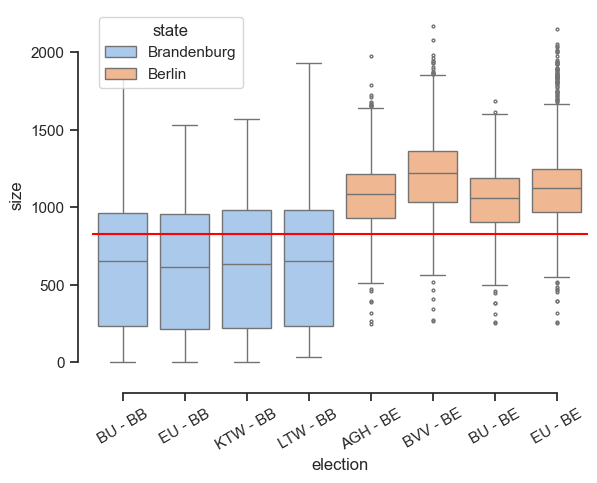

In [82]:

sns.set_theme(style="ticks", palette="pastel")

graph = sns.boxplot(
    x='election',
    y='size',
    hue='state',
    data=electoral_district,
    fliersize=2
)

sns.despine(offset=10, trim=True)

graph.set_xticklabels(graph.get_xticklabels(), rotation=30)
graph.axhline(
    y=electoral_district.loc[:, 'size'].mean(), 
    label='mean',
    color='red'
    )


### Estimating Electoral Districts Based on Population

The visualizations reveal a clear difference in electoral district size between urban areas (e.g., Berlin) and rural regions (e.g., Brandenburg). While the **type of region** significantly influences district size, the **type of election** (e.g., federal, European) has only a minor effect and can be considered negligible for this purpose.

To estimate the number of electoral districts based on population, we use the **average number of eligible voters per district** as a conversion factor. Our analysis shows that, on average, one electoral district corresponds to approximately **800 eligible voters**.

For the number of eligible voters, we refer to the official figures from the **2025 federal election (Bundestagswahl)**, which represent the most up-to-date nationwide data. According to the Federal Election Officer, **60,510,631** people were eligible to vote in that election ([source](https://www.bundeswahlleiterin.de/bundestagswahlen/2025/ergebnisse/bund-99.html#stimmentabelle14)).

We note that this figure excludes some younger voters who are eligible in certain elections (e.g., from age 16 in European or local elections). However, we consider this deviation negligible for the purpose of high-level market estimation.

Using this approach, the total number of electoral districts in Germany can be approximated by dividing the number of eligible voters by mean size of electorial districts.


In [83]:
number_of_eligible_voters = 60_510_631
mean_electoral_district_size = electoral_district.loc[:, 'size'].mean()
price_per_electoral_district = 50
service_fee = round(number_of_eligible_voters / mean_electoral_district_size * price_per_electoral_district / 1_000_000, 1)

print(f'Service fee per election ~ €{service_fee}M')


Service fee per election ~ €3.7M


### Identifying Potential Customers: Municipalities

As a next step, we aim to estimate the number of potential customers by identifying all municipalities (*Gemeinden*) in Germany. Each municipality typically operates one or more electoral districts and would represent a unit of demand for our product.

To do this, we rely on data from the **Official Municipality Directory (GV-ISys)**, maintained by the Federal Statistical Office ([Destatis – Gemeindeverzeichnis](https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/_inhalt.html)). This dataset provides detailed information on:

- The total number of municipalities in Germany,
- Their population sizes,
- Administrative structures ([RS](https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Glossar/regionalschluessel.html)).

This data allows us to classify municipalities by size and estimate demand tiers. In a subsequent step, we will multiply the number of municipalities by a fixed fee per customer to estimate the market potential for our base product offering.


In [84]:
def size_category(row):
    if row['Population'] < 10_000:
        return '< 10.000'
    if row['Population'] > 50_000:
        return '> 50.000'
    return '5.000 - 50.000'


municipalities = pd.read_excel('AuszugGV2QAktuell.xlsx', sheet_name='Onlineprodukt_Gemeinden30062025', usecols='C:J', skiprows=6, names=['Land', 'RB', 'Kreis', 'VB', 'Gem', 'Name', 'Size', 'Population'], dtype=str)
municipalities = municipalities.loc[municipalities['Size'].notna() & municipalities['Population'].notna()]
municipalities['Population'] = municipalities['Population'].astype(int)
municipalities['Size category'] = municipalities.apply(size_category, axis=1)
municipalities.head()


,Land,RB,Kreis,VB,Gem,Name,Size,Population,Size category
2,01,0,01,0000,000,"Flensburg, Stadt",56.73,96431,> 50.000
5,01,0,02,0000,000,"Kiel, Landeshauptstadt",118.65,251751,> 50.000
8,01,0,03,0000,000,"Lübeck, Hansestadt",214.19,217061,> 50.000
11,01,0,04,0000,000,"Neumünster, Stadt",71.66,79461,> 50.000
14,01,0,51,0011,011,"Brunsbüttel, Stadt",65.21,12736,5.000 - 50.000


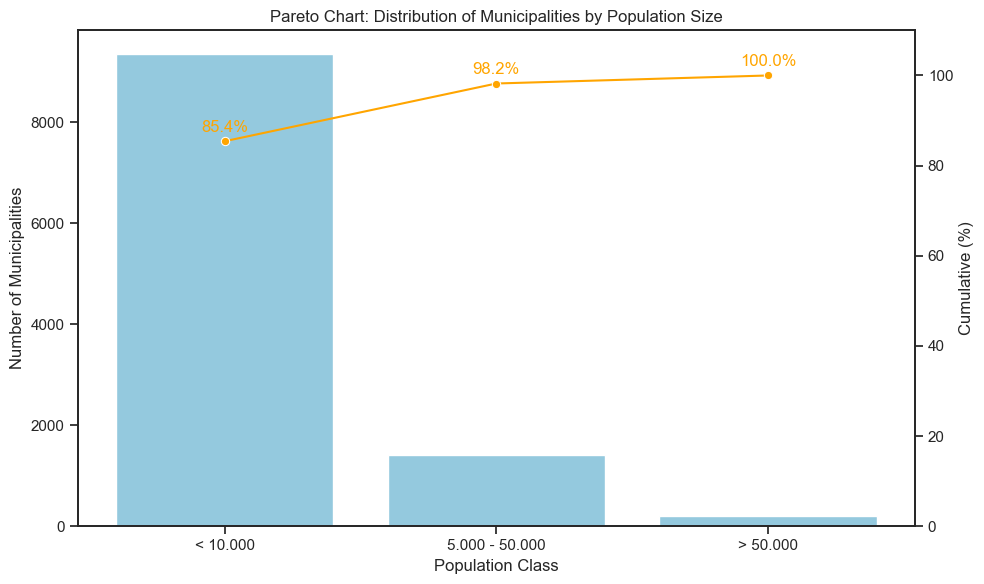

In [85]:
counts = municipalities["Size category"].value_counts().sort_values(ascending=False)
municipalities_pareto = counts.reset_index()
municipalities_pareto.columns = ["Size category", "count"]

municipalities_pareto["cumulative"] = municipalities_pareto["count"].cumsum()
municipalities_pareto["cumulative_pct"] = municipalities_pareto["cumulative"] / municipalities_pareto["count"].sum() * 100

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(x="Size category", y="count", data=municipalities_pareto, ax=ax1, color="skyblue")
ax1.set_ylabel("Number of Municipalities")
ax1.set_xlabel("Population Class")

ax2 = ax1.twinx()
sns.lineplot(x="Size category", y="cumulative_pct", data=municipalities_pareto, ax=ax2, color="orange", marker="o")
ax2.set_ylabel("Cumulative (%)")
ax2.set_ylim(0, 110)

for x, y in enumerate(municipalities_pareto["cumulative_pct"]):
    ax2.text(x, y + 2, f"{y:.1f}%", ha="center", color="orange")

plt.title("Pareto Chart: Distribution of Municipalities by Population Size")
plt.tight_layout()
plt.show()


### Assumption: License Agreements at the Level of Municipal Associations

Given the distribution of municipality sizes in Germany with over 80% having fewer than 10.000 inhabitants. We assume that software license agreements are not concluded at the level of individual small municipalities. Instead, it is more realistic to assume that contracts are managed at the level of **municipal associations** (_Gemeindeverbände_), which pool administrative resources.

We therefore consider the **number of municipal associations** in Germany as a more accurate proxy for the number of potential customers.


In [86]:
costumer = municipalities[['Land', 'RB', 'Kreis', 'VB']].drop_duplicates().shape[0]
lisenz_cost = 1_000

print(f'License per election ~ €{round(costumer * lisenz_cost / 1_000_000, 1)}M')


License per election ~ €4.6M
